## Poročilo vaja 3.1
#### Preverjanje hipotez v članku: An empirical study of race times in recreational endurance runners

Imamo podatke o tekačih maratona: *running_marathon_po_clanku.sav*

Zanima nas, ali obstajajo statistično značilne razlike v različnih količinah med tekači, ki pretečejo maraton pod 3h in tekači, ki pretečejo maraton med 3:00 in 3:30.
1. Izvedi opisno statistiko glede na ti dve skupini.
2. Opremi opisno statistiko z ustreznimi grafi.
3. Izvedi ustrezne statistične teste in ugotovi, kje so razlike statistično značilne.
4. Uporabi ustrezno statistično metodologijo in jo ustrezno zapiši.
5. Ustrezno predstavi rezultate in jih komentiraj.
6. Podaj končne zaključke analize.

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import shapiro, mannwhitneyu

In [141]:
# upload and clean data
path = os.getcwd()
data = pd.read_excel(path + "\\data\\running_marathon_po_clanku_preproc.xlsx")
pd.set_option('display.max_columns', None)
runners = data[['age', 'bmi', 'female', 'endurancecat', 'footwear', 'typical', 'k5_ti', 'mh_ti', 'mf_ti']].copy()
runners['mf_ti_cat'] = pd.Categorical(np.where(runners['mf_ti'] < 10800, '<3h', np.where(runners['mf_ti'] < 12600, '<3h30min', pd.NA)))

runners = runners[runners['mf_ti_cat'].notna()]
runners.footwear = runners.footwear.map({
    1: 'Normal running shoes',
    2: 'Minimalist',
    3: 'Barefoot'
})
runners.endurancecat = runners.endurancecat.map({
    1: 'Strictly endurance',
    2: 'Generally endurance', 
    3: 'Generally speed', 
    4: 'Strictly speed'
})
runners.head()

,age,bmi,female,endurancecat,footwear,typical,k5_ti,mh_ti,mf_ti,mf_ti_cat
3,35.00,23.59,0,Generally endurance,Minimalist,50.00,1075.00,NaN,10295.00,<3h
6,33.00,22.52,0,Generally endurance,Minimalist,40.00,1292.00,5760.00,12292.00,<3h30min
11,38.00,25.56,0,Strictly endurance,Minimalist,50.00,NaN,NaN,10980.00,<3h30min
12,34.00,22.61,0,Strictly endurance,Minimalist,80.00,NaN,4995.00,10694.00,<3h
18,20.00,22.90,0,Strictly endurance,Normal running shoes,80.00,893.00,NaN,9515.00,<3h


**Preverimo normalnost porazdelitve spremenljivk:**

Ugotovimo, da so vse spremenljivke nenormalno porazdeljene

In [142]:
# groupby time and check for normality of the variables
rfast = runners[runners['mf_ti_cat'] == '<3h']
N_fast = rfast.shape[0]
rslow = runners[runners['mf_ti_cat'] != '<3h']
N_slow = rslow.shape[0]

variables = ['age', 'bmi', 'typical', 'k5_ti', 'mh_ti']
for v in variables:
    value = runners[v].dropna()
    stat, p = shapiro(value)
    print(f'Shapiro-Wilk Test Statistic for {v}: {stat:.4f}')
    print(f'p-value: {p:.4f}')
    if p < 0.05:
        print(f'    {v} is non-normally distributed.')
    else:
        print(f'    {v} is normally distributed.')    

Shapiro-Wilk Test Statistic for age: 0.9677
p-value: 0.0000
    age is non-normally distributed.
Shapiro-Wilk Test Statistic for bmi: 0.9796
p-value: 0.0000
    bmi is non-normally distributed.
Shapiro-Wilk Test Statistic for typical: 0.9544
p-value: 0.0000
    typical is non-normally distributed.
Shapiro-Wilk Test Statistic for k5_ti: 0.8895
p-value: 0.0000
    k5_ti is non-normally distributed.
Shapiro-Wilk Test Statistic for mh_ti: 0.9605
p-value: 0.0000
    mh_ti is non-normally distributed.


In [143]:
table_one = []

table_one.append(['N', f'{rfast.shape[0]}', f'{rslow.shape[0]}'])
table_one.append(['Age', f'{rfast.age.median():.1f} ({rfast.age.quantile(.75)-rfast.age.quantile(.25):.1f})', f'{rslow.age.median():.1f} ({rslow.age.quantile(.75)-rslow.age.quantile(.25):.1f})']) 
table_one.append(['BMI', f'{rfast.bmi.median():.1f} ({rfast.bmi.quantile(.75)-rfast.bmi.quantile(.25):.1f})',f'{rslow.bmi.median():.1f} ({rslow.bmi.quantile(.75)-rslow.bmi.quantile(.25):.1f})']) 
table_one.append(['Gender', '', ''])
table_one.append(['- Male', f'{rfast.female.value_counts()[0]} ({(rfast.female.value_counts()[0]/N_fast)*100:.1f}%)', f'{rslow.female.value_counts()[0]} ({(rslow.female.value_counts()[0]/N_slow)*100:.1f}%)'])
table_one.append(['- Female', f'{rfast.female.value_counts()[1]} ({(rfast.female.value_counts()[1]/N_fast)*100:.1f}%)', f'{rslow.female.value_counts()[1]} ({(rslow.female.value_counts()[1]/N_slow)*100:.1f}%)'])
table_one.append(['Weekly mileage', f'{rfast.typical.median():.1f} ({rfast.typical.quantile(.75)-rfast.typical.quantile(.25):.1f})', f'{rslow.typical.median():.1f} ({rslow.typical.quantile(.75)-rslow.typical.quantile(.25):.1f})'])
table_one.append(['Footwear', '', ''])
table_one.append(['- Normal running shoes', f'{rfast.footwear.value_counts().iloc[0]} ({(rfast.footwear.value_counts().iloc[0]/N_fast)*100:.1f}%)', f'{rslow.footwear.value_counts().iloc[0]} ({(rslow.footwear.value_counts().iloc[0]/N_slow)*100:.1f}%)'])
table_one.append(['- Minimalist', f'{rfast.footwear.value_counts().iloc[1]} ({(rfast.footwear.value_counts().iloc[1]/N_fast)*100:.1f}%)', f'{rslow.footwear.value_counts().iloc[1]} ({(rslow.footwear.value_counts().iloc[1]/N_slow)*100:.1f}%)'])
table_one.append(['- Barefoot', f'{rfast.footwear.value_counts().iloc[2]} ({(rfast.footwear.value_counts().iloc[2]/N_fast)*100:.1f}%)', f'{rslow.footwear.value_counts().iloc[2]} ({(rslow.footwear.value_counts().iloc[2]/N_slow)*100:.1f}%)'])
table_one.append(['Training category', '', ''])
table_one.append(['- Strictly endurance', f'{rfast.endurancecat.value_counts().iloc[0]} ({(rfast.endurancecat.value_counts().iloc[0]/N_fast)*100:.1f}%)', f'{rslow.endurancecat.value_counts().iloc[0]} ({(rslow.endurancecat.value_counts().iloc[0]/N_slow)*100:.1f}%)'])
table_one.append(['- Generally endurance', f'{rfast.endurancecat.value_counts().iloc[1]} ({(rfast.endurancecat.value_counts().iloc[1]/N_fast)*100:.1f}%)', f'{rslow.endurancecat.value_counts().iloc[1]} ({(rslow.endurancecat.value_counts().iloc[1]/N_slow)*100:.1f}%)'])
table_one.append(['- Generally speed', f'{rfast.endurancecat.value_counts().iloc[2]} ({(rfast.endurancecat.value_counts().iloc[2]/N_fast)*100:.1f}%)', f'{rslow.endurancecat.value_counts().iloc[2]} ({(rslow.endurancecat.value_counts().iloc[2]/N_slow)*100:.1f}%)'])
table_one.append(['- Strictly speed', f'{rfast.endurancecat.value_counts().iloc[3]} ({(rfast.endurancecat.value_counts().iloc[3]/N_fast)*100:.1f}%)', f'{rslow.endurancecat.value_counts().iloc[3]} ({(rslow.endurancecat.value_counts().iloc[3]/N_slow)*100:.1f}%)'])

summary_df = pd.DataFrame(table_one, columns=['', '<3h', '<3h30min'])
summary_df.style.set_caption(f'Table 1: Characteristics of study participants')\
          .set_table_styles([
              {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                ('font-weight', 'bold'), 
                                                ('border-bottom', '1px solid black'),
                                                ('width', '100%')]},
              {'selector': 'td', 'props': 'text-align: left;'}
          ])\
          .hide()

,<3h,<3h30min
N,145,287
Age,34.0 (10.0),35.0 (13.0)
BMI,22.1 (2.5),22.5 (2.5)
Gender,,
- Male,137 (94.5%),210 (73.2%)
- Female,8 (5.5%),77 (26.8%)
Weekly mileage,60.0 (25.0),45.0 (15.0)
Footwear,,
- Normal running shoes,104 (71.7%),211 (73.5%)
- Minimalist,40 (27.6%),72 (25.1%)


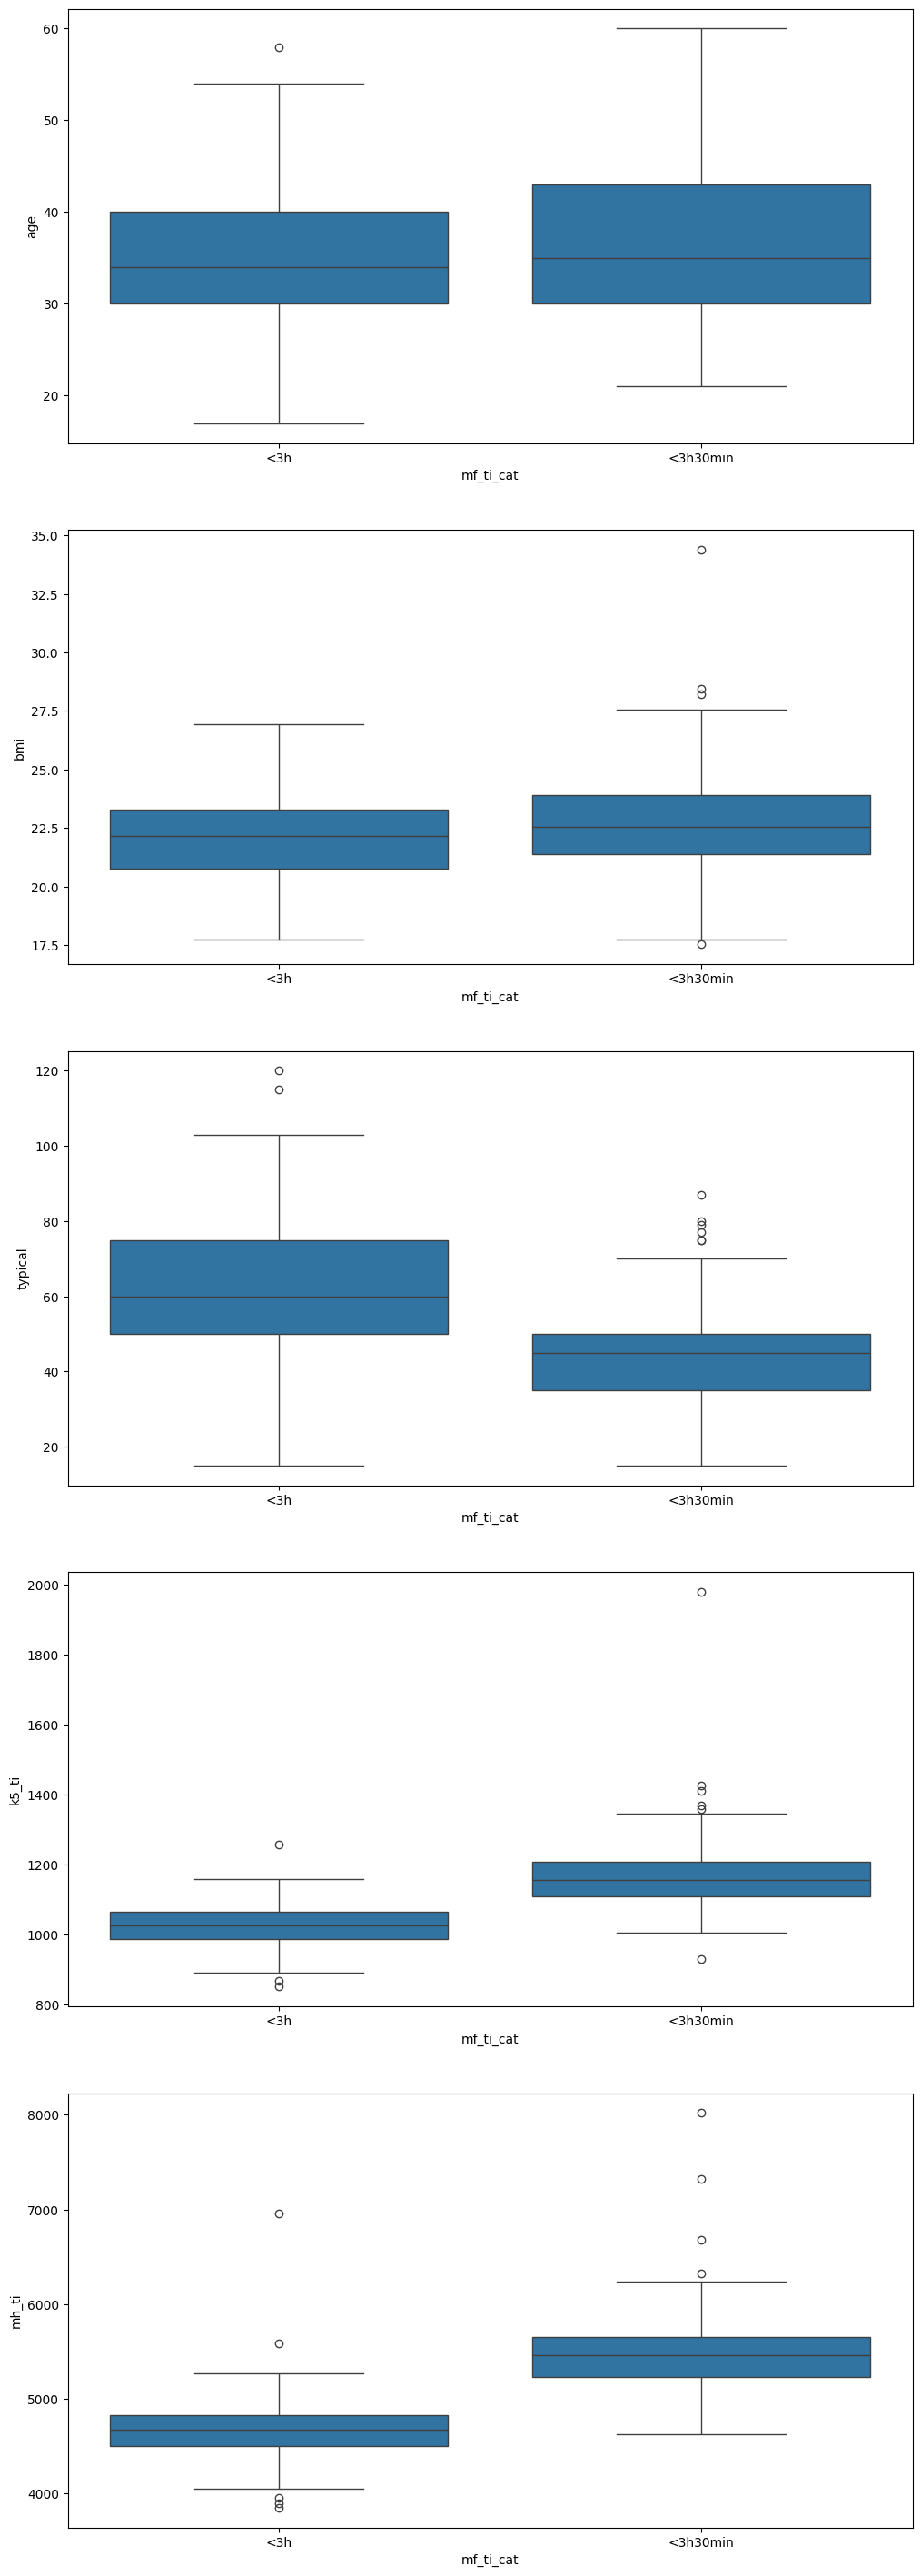

In [145]:
fig, axes = plt.subplots(5, figsize=(12,36))
variables = {'starost': 'age', 'BMI': 'bmi', 'pretečeni km/teden': 'typical', 'čas teka 5km [s]': 'k5_ti', 'čas teka 21km [s]': 'mh_ti'}
for i, var in enumerate(variables.values()):
    sns.boxplot(data=runners, x='mf_ti_cat', y=var, ax=axes[i])


Iz grafov lahko vidimo, da statistično značilnost nakazujeta spremenljivki **typical**, **k5_ti** in **mh_ti**, torej tedensko pretečeni kilometri, najhitrejši čas na 5-km razdalji in najhitrejši čas na pol-maratonski razdalji. To bomo preverili še z Mann-Withney U testom. Za uporabo tega testa smo se odločili, ker so vse obravnavane spremenljivke nenormalno porazdeljene.

In [148]:
t_test_results = []

for var in variables.values():  
    stat, p = mannwhitneyu(rfast[var].dropna(), rslow[var].dropna(), alternative='two-sided')
    
    t_test_results.append({
        '': var,
        'U statistic': f'{round(stat, 2):.2f}',
        'p-value': '<0.01' if p < 0.01 else f'{round(p, 3):.2f}'
    })

results_df = pd.DataFrame(t_test_results)

display(results_df.style.set_caption(f'Table 2: Mann-Whitney U test')\
          .set_table_styles([
              {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                ('font-weight', 'bold'), 
                                                ('border-bottom', '1px solid black'),
                                                ('width', '100%')]},
              {'selector': 'td', 'props': 'text-align: left;'}
          ])\
          .hide())

,U statistic,p-value
age,18800.50,0.10
bmi,16934.50,<0.01
typical,33900.00,<0.01
k5_ti,705.50,<0.01
mh_ti,819.50,<0.01


**Interpretacija:** Iz tabele lahko razberemo, da samo razlika med povprečji spremenljivke *age* za skupini *<3h* in *<3h30min* ni statistično značilna. Razlike povprečij vseh ostalih spremenljivk za ti dve skupini so statistično značilne. Povedano po domače: tekači, ki pretečejo maraton v manj kot treh urah se v povprečju razlikujejo v indeksu telesne mase, pretečenih kilometrih na teden, najhitrejšem času na 5km in 21km razdalji od tekačev, ki maraton pretečejo v časovnem okviru od treh ur do treh ur in pol.